In [2]:
import portfolioTheory as pt
import yftickers as ticks
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
from scipy.stats import kurtosis
from scipy.stats import norm
from scipy.stats import probplot
import yfinance as yf
import statsmodels.api as sm
import pylab
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

# Data collection

In [3]:
tickers = ticks.ftse100
start=dt.datetime(2000,1,1)
end=dt.datetime(2023,1,1)
threshold=0.9

In [4]:
portfolio = pt.Portfolio(tickers, start, end)
portfolio.getData()
portfolio.cleanData(dateRange=['2002','2023'], threshold=threshold)
portfolio.calculate_stats()

[*********************100%***********************]  101 of 101 completed

4 Failed downloads:
- AVV.L: No data found, symbol may be delisted
- AUTO: No timezone found, symbol may be delisted
- MGGT.L: No timezone found, symbol may be delisted
- RMG.L: No timezone found, symbol may be delisted
34 columns were removed because there were less observations than the threshold (0.9):
AAL       73.20%
ABDN.L    70.15%
AHT       82.06%
AUTO       0.00%
AVV.L      0.00%
BME       75.34%
BRBY.L    87.60%
CCH.L     41.20%
CPG       81.42%
EDV       63.31%
ENT.L     76.87%
EXPN.L    69.06%
FLTR      49.55%
FRES.L    62.34%
GLEN.L    49.39%
HIK.L     73.07%
HL.L      66.55%
IAG       82.57%
IHG       83.66%
III       67.39%
INVR.L    61.61%
ITRK.L    88.18%
LAND      42.11%
MGGT.L     0.00%
MNDI.L    66.01%
NWG       64.48%
OCDO.L    52.96%
PHNX.L    55.82%
PRU       89.25%
RMG.L      0.00%
RMV.L     71.53%
SKG.L     67.24%
SMIN      46.18%
UTG       79.96%
dtype: object


In [5]:
portfolio.raw_data.to_csv('portfolio_data_all_raw.csv')

#### Benchmarks

In [6]:
ftse = yf.download('^FTSE', start=dt.datetime(2002,1,1), end=dt.datetime(2023,1,1))['Adj Close']
ftseLogReturn = np.log(ftse/ftse.shift(1))

[*********************100%***********************]  1 of 1 completed


In [7]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.logReturns.cov()
equallyWeights = pt.equallyWeighted(meanReturns, covMatrix)[1][1]

# EDA

In [8]:
print('{} years and {} average days'.format(len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),round(len(portfolio.logReturns)/len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),3)))

21 years and 236.952 average days


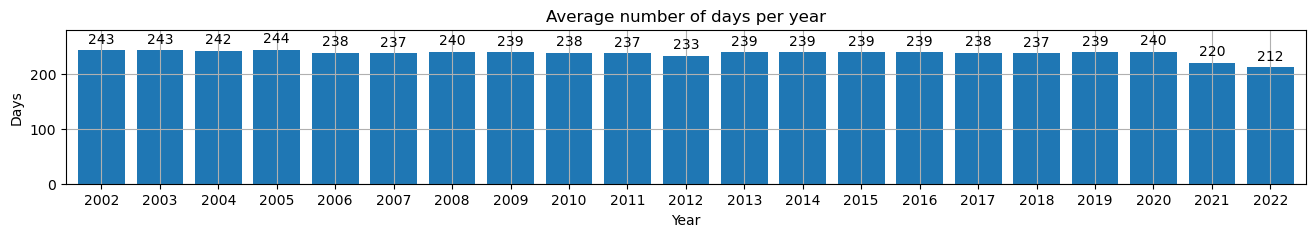

In [9]:
avDays = portfolio.logReturns.groupby(portfolio.logReturns.index.year).count().mean(axis=1)
fig = plt.figure(figsize=(16,2))
plt.bar(avDays.index,avDays.values)
plt.xticks(avDays.index)
plt.ylim(0,280)
plt.margins(x=0.01)
plt.grid()
plt.ylabel('Days')
plt.xlabel('Year')
plt.title('Average number of days per year')
for x,y in zip(avDays.index,avDays.values):

    label = "{}".format(int(y))

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')
plt.show()

In [10]:
fig = px.bar(avDays, x=avDays.index, y=avDays.values, width=800, height=300, text_auto=True, range_y=(0,300), title='Average number of days per year')
fig.update_traces(textfont_size=12, textposition="outside", cliponaxis=False)
fig.update_xaxes(tickmode='linear',tickangle= -90)
fig.update_layout(yaxis_title="Count of days")
fig.show()

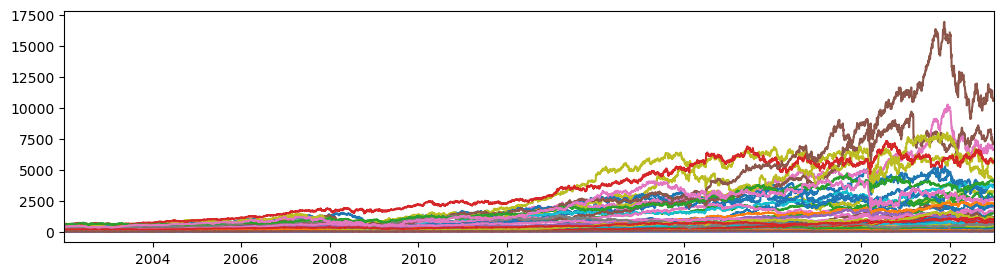

In [11]:
plt.figure(figsize=(12,3))
plt.plot(portfolio.raw_data['Adj Close'])
plt.margins(x=0)
plt.savefig('media/prices')
plt.show()

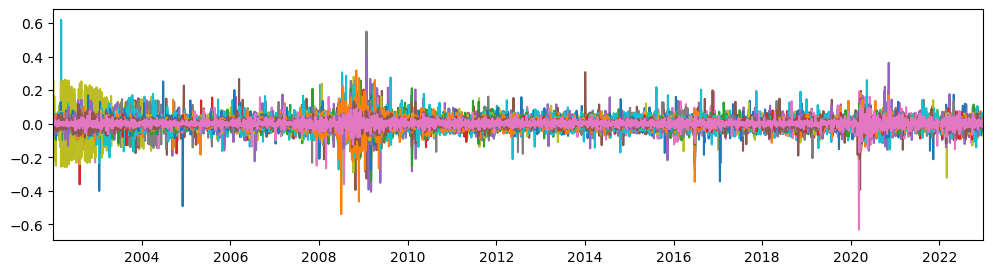

In [12]:
plt.figure(figsize=(12,3))
plt.plot(portfolio.logReturns)
plt.margins(x=0)
plt.savefig('media/Returns')
plt.show()

In [13]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix
portfolio.calculate_PortPerformance(pt.equallyWeighted(meanReturns,covMatrix)[1][1])

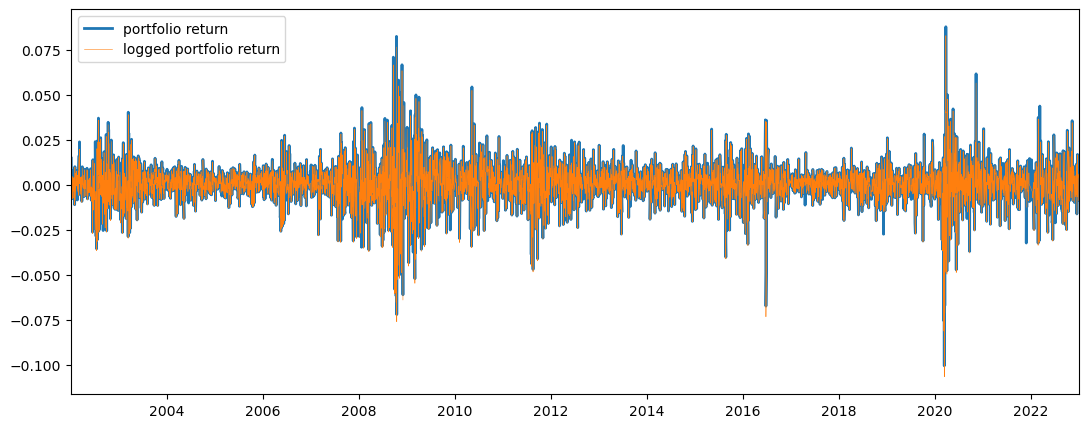

In [14]:
plt.figure(figsize=(13,5))
plt.plot(portfolio.portReturns, lw=2, label='portfolio return')
plt.plot(portfolio.portlogReturns, lw=0.4, label='logged portfolio return')
plt.legend()
plt.margins(x=0)
plt.savefig('media/portReturns')
plt.show()

In [15]:
px.imshow(portfolio.logReturns.corr())

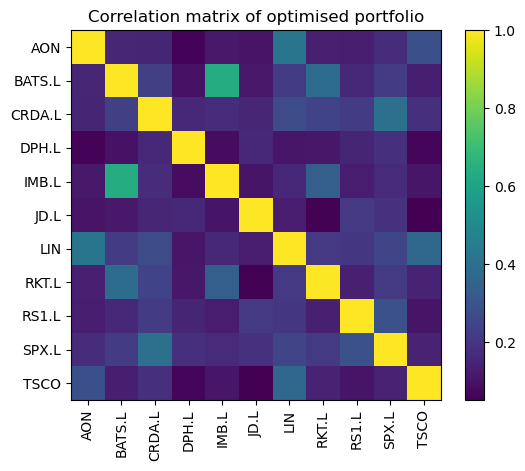

In [17]:
df = pd.DataFrame(index=pt.maxSharpeRatio(meanReturns,covMatrix)[1][0], data=pt.maxSharpeRatio(meanReturns,covMatrix)[1][1])
df.rename(columns={0:'weights'}, inplace=True)
#px.imshow(portfolio.logReturns[df[df['weights']>0.0000001].index].corr(), title='Correlation matrix of optimised portfolio')
#plt.figure(figsize=(5,3))
plt.imshow(portfolio.logReturns[df[df['weights']>0.0000001].index].corr())
plt.title('Correlation matrix of optimised portfolio')
plt.yticks(ticks=range(0,11,1), labels=df[df['weights']>0.0000001].index.to_list())
plt.xticks(ticks=range(0,11,1), labels=df[df['weights']>0.0000001].index.to_list(),rotation = 90)
plt.colorbar()
plt.savefig('Media/Correlation matrix of optimised portfolio')
plt.show()

In [18]:
df = pd.concat([portfolio.portReturns,portfolio.portlogReturns], axis=1)

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio.portReturns.index, y=portfolio.portReturns,
                    mode='lines',
                    name='Returns',
                        marker_size=1,
                        marker_line_width=0.001,
                        line_color='red')
             )
fig.add_trace(go.Scatter(x=portfolio.portlogReturns.index, y=portfolio.portlogReturns,
                    mode='lines',
                    name='Log returns',
                        marker_size=1,
                        marker_line_width=0.01,
                        line_color='blue',
                        opacity=0.7)
             )
fig.update_layout(
    title="Comparing returns with log returns",
    xaxis_title="Date",
    yaxis_title="Returns",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

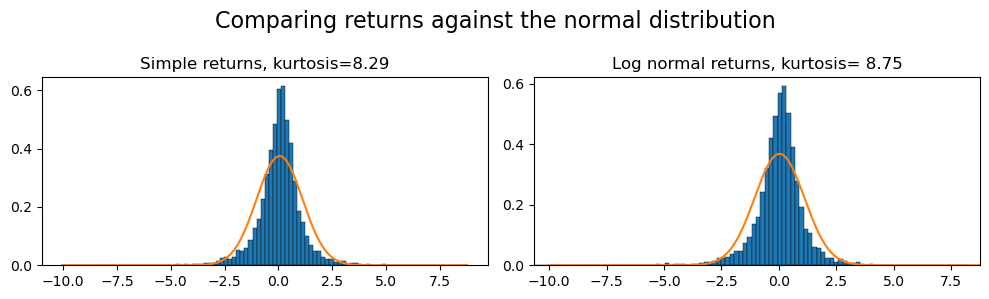

In [20]:
x = np.linspace(portfolio.portReturns.min(),portfolio.portReturns.max(),len(portfolio.portReturns))*100
mu0 = portfolio.portReturns.mean()*100
sigma0 = portfolio.portReturns.std()*100
mu1 = portfolio.portlogReturns.mean()*100
sigma1 = portfolio.portlogReturns.std()*100
fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(portfolio.portReturns*100, bins =100, density=True,edgecolor='black',linewidth=0.3)
ax[0].plot(x, norm.pdf(x, loc=mu0, scale=sigma0))
ax[0].set_title('Simple returns, kurtosis={}'.format(round(kurtosis(portfolio.portReturns, bias=False),2)))
ax[1].hist(portfolio.portlogReturns*100, bins =100, density=True,edgecolor='black',linewidth=0.3)
ax[1].plot(x, norm.pdf(x, loc=mu1, scale=sigma1))
ax[1].set_title('Log normal returns, kurtosis= {}'.format(round(kurtosis(portfolio.portlogReturns, bias=False),2)))
plt.margins(x=0)
fig.suptitle('Comparing returns against the normal distribution', fontsize=16)
plt.tight_layout()
plt.savefig('media/Ndistribution')
plt.show()

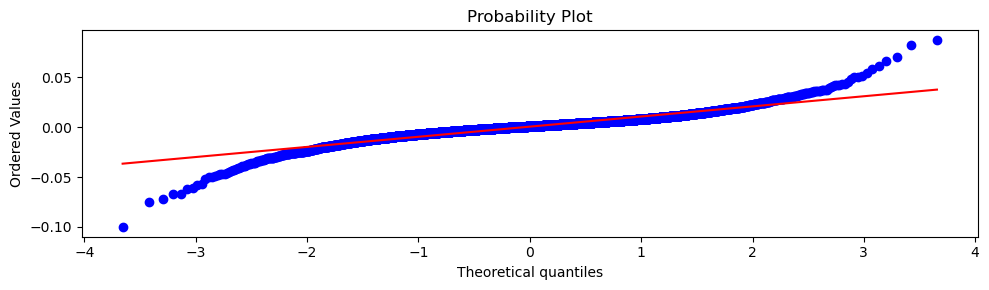

In [21]:
plt.figure(figsize=(10,3))
probplot(portfolio.portReturns, dist="norm", plot=pylab)
plt.tight_layout()
plt.savefig('media/QQ plot')
plt.show()

# Portfolio optimisation

## Initial set up

In [22]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix

In [23]:
maxSR0001 = pt.maxSharpeRatio(meanReturns,covMatrix,constraintSet=(0.0001, 1))
maxSR001 = pt.maxSharpeRatio(meanReturns,covMatrix,constraintSet=(0.001, 1))
maxSR01 = pt.maxSharpeRatio(meanReturns,covMatrix,constraintSet=(0.01, 1))
maxSR = pt.maxSharpeRatio(meanReturns,covMatrix)

C:\Users\44756\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



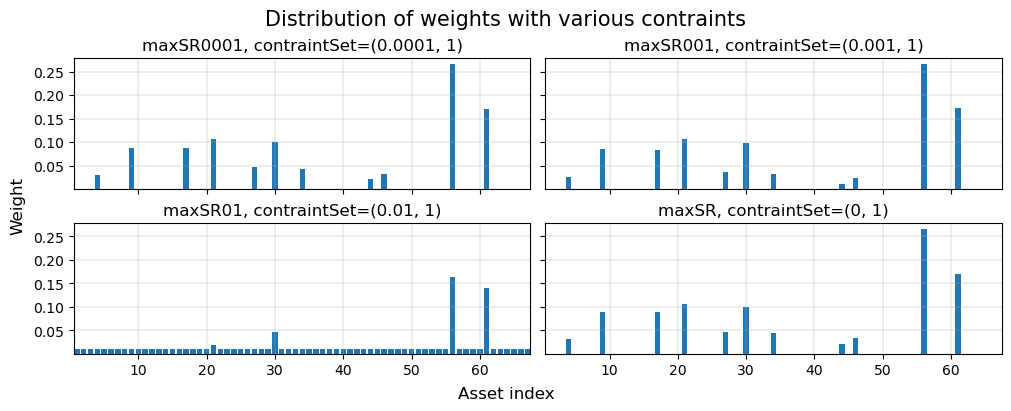

In [24]:
fig, axs = plt.subplots(2,2,figsize=(10,4), layout='constrained', sharey=True, sharex=True)
fig.suptitle('Distribution of weights with various contraints', fontsize=15)
fig.supylabel('Weight')
fig.supxlabel('Asset index')
axs[0][0].bar(np.arange(1,len(maxSR0001[1][1])+1),height=maxSR0001[1][1])
axs[0][0].set_title('maxSR0001, contraintSet=(0.0001, 1)')
axs[0][1].bar(np.arange(1,len(maxSR001[1][1])+1),height=maxSR001[1][1])
axs[0][1].set_title('maxSR001, contraintSet=(0.001, 1)')
axs[1][0].bar(np.arange(1,len(maxSR01[1][1])+1),height=maxSR01[1][1])
axs[1][0].set_title('maxSR01, contraintSet=(0.01, 1)')
axs[1][1].bar(np.arange(1,len(maxSR[1][1])+1),height=maxSR[1][1])
axs[1][1].set_title('maxSR, contraintSet=(0, 1)')
for i in axs.flatten():
    i.yaxis.set_ticks([0.05,0.1,0.15,0.2,0.25])
    i.grid(visible=True,which='both',linewidth=0.3)
    i.margins(x=0)
plt.savefig('media/ConstrainedWeightsDistribution')
plt.show()

In [25]:
df = pd.concat([pd.DataFrame(maxSR[1]),
                 pd.DataFrame(maxSR0001[1]), 
                 pd.DataFrame(maxSR001[1]), 
                 pd.DataFrame(maxSR01[1])], axis=0)
df.columns = df.iloc[0]
df = df[1:]
df.index.name = None
df

0   ABF.L     ADM  ANTO.L       AON    AV.L     AZN    BA.L  BARC.L    BATS.L  \
1     0.0     0.0     0.0  0.031042     0.0     0.0     0.0     0.0  0.088435   
0   ABF.L     ADM  ANTO.L       AON    AV.L     AZN    BA.L  BARC.L    BATS.L   
1  0.0001  0.0001  0.0001  0.030444  0.0001  0.0001  0.0001  0.0001  0.088075   
0   ABF.L     ADM  ANTO.L       AON    AV.L     AZN    BA.L  BARC.L    BATS.L   
1   0.001   0.001   0.001  0.025053   0.001   0.001   0.001   0.001  0.084949   
0   ABF.L     ADM  ANTO.L       AON    AV.L     AZN    BA.L  BARC.L    BATS.L   
1    0.01    0.01    0.01      0.01    0.01    0.01    0.01    0.01      0.01   

0  BDEV.L  ...  STAN.L   STJ.L     SVT      TSCO    TW.L  ULVR.L    UU.L  \
1     0.0  ...     0.0     0.0     0.0  0.169561     0.0     0.0     0.0   
0  BDEV.L  ...  STAN.L   STJ.L     SVT      TSCO    TW.L  ULVR.L    UU.L   
1  0.0001  ...  0.0001  0.0001  0.0001  0.169888  0.0001  0.0001  0.0001   
0  BDEV.L  ...  STAN.L   STJ.L     SVT      TSCO    TW.L  ULVR.L    UU.L   
1   0.001  ...   0.001   0.001   0.001  0.173027   0.001   0.001   0.001   
0  BDEV.L  ...  STAN.L   STJ.L     SVT      TSCO    TW.L  ULVR.L    UU.L   
1    0.01  ...    0.01    0.01    0.01  0.139847    0.01    0.01    0.01   

0     VOD     WPP   WTB.L  
1     0.0     0.0     0.0  
0     VOD     WPP   WTB.L  
1  0.0001  0.0001  0.0001  
0     VOD     WPP   WTB.L  
1   0.001   0.001   0.001  
0     VOD     WPP   WTB.L  
1    0.01    0.01    0.01  

[7 rows x 67 columns]

In [26]:
df.rename(columns=df.iloc[0]).drop(df.index[0])

0 0.000000e+00 0.000000e+00 3.673965e-16 3.104204e-02 3.832107e-15  \
0        ABF.L          ADM       ANTO.L          AON         AV.L   
0        ABF.L          ADM       ANTO.L          AON         AV.L   
0        ABF.L          ADM       ANTO.L          AON         AV.L   

0 0.000000e+00 2.187350e-16 3.048614e-15 8.843527e-02 1.617132e-15  ...  \
0          AZN         BA.L       BARC.L       BATS.L       BDEV.L  ...   
0          AZN         BA.L       BARC.L       BATS.L       BDEV.L  ...   
0          AZN         BA.L       BARC.L       BATS.L       BDEV.L  ...   

0 6.944631e-16 5.795836e-16 0.000000e+00 1.695607e-01 0.000000e+00  \
0       STAN.L        STJ.L          SVT         TSCO         TW.L   
0       STAN.L        STJ.L          SVT         TSCO         TW.L   
0       STAN.L        STJ.L          SVT         TSCO         TW.L   

0 0.000000e+00 0.000000e+00 8.735910e-16 4.350312e-17 1.749054e-16  
0       ULVR.L         UU.L          VOD          WPP        WTB.L  
0       ULVR.L         UU.L          VOD          WPP        WTB.L  
0       ULVR.L         UU.L          VOD          WPP        WTB.L  

[3 rows x 67 columns]

In [28]:
df = (pd.DataFrame(maxSR[1]).T)
df.set_index(0)

1
0               
ABF.L        0.0
ADM          0.0
ANTO.L       0.0
AON     0.031042
AV.L         0.0
...          ...
ULVR.L       0.0
UU.L         0.0
VOD          0.0
WPP          0.0
WTB.L        0.0

[67 rows x 1 columns]

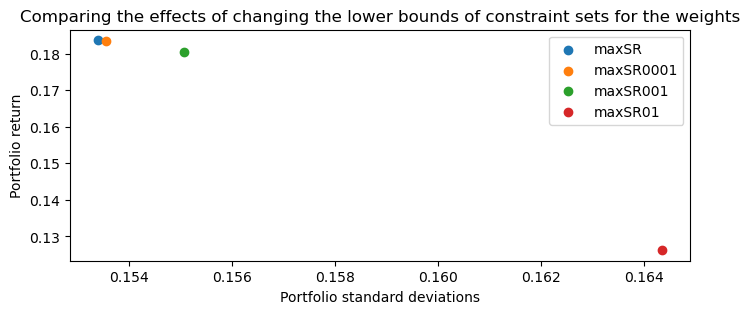

In [29]:
weights_dist_str = ['maxSR', 'maxSR0001', 'maxSR001', 'maxSR01']
weights_dist = [maxSR, maxSR0001, maxSR001, maxSR01]
weights_dist_performance = {}
for i,x in enumerate(weights_dist):
    weights_dist_performance[weights_dist_str[i]]=pt.portfolioPerformance(x[1][1], meanReturns,covMatrix)
df = pd.DataFrame(weights_dist_performance).T
df.rename(columns={0:'returns', 1:'std'}, inplace=True)
plt.figure(figsize=(8,3))
for i in weights_dist_str:
    plt.scatter(y=df.loc[i][0], x=df.loc[i][1], label=i)
plt.title('Comparing the effects of changing the lower bounds of constraint sets for the weights')
plt.ylabel('Portfolio return')
plt.xlabel('Portfolio standard deviations')
plt.legend()
plt.savefig('media/PerformanceOfContraintedWeights')
plt.show()

pt.EF_graph(portfolio.logReturns.mean(), portfolio.covMatrix)

# No reset

In [30]:
maxSharpeWeights = pt.maxSharpeRatio(meanReturns, covMatrix)[1][1]
noReset = portfolio.logReturns@maxSharpeWeights

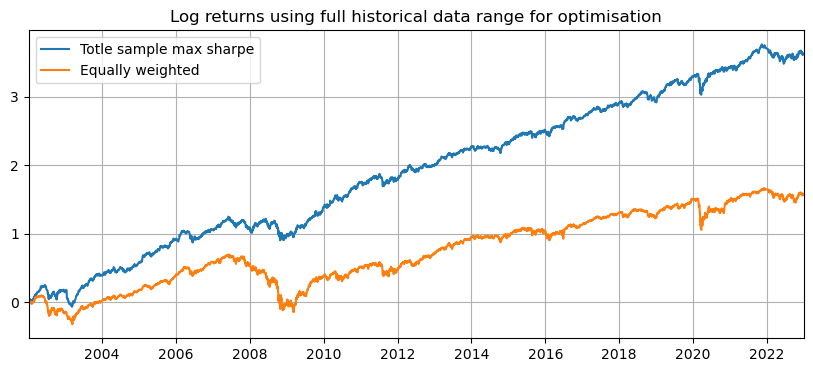

In [31]:
plt.figure(figsize=(10,4))
plt.title('Log returns using full historical data range for optimisation')
plt.margins(x=0)
plt.plot(np.cumsum(noReset), label='Totle sample max sharpe')
plt.plot(np.cumsum(portfolio.portlogReturns), label='Equally weighted')
plt.legend()
plt.grid()
plt.savefig('media/simply_vs_maxSharpe')
plt.show()

# Testing the reset intervals

### In sample

In [32]:
# Annual
annualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
annualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('Y',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    annualReset['ret'][x.index] = portfolio.logReturns.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T 
#Bannual
biAnnualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
biAnnualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('6M',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    biAnnualReset['ret'][x.index] = portfolio.logReturns.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
#Quarterly
quarterlyReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
quarterlyReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('Q',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    quarterlyReset['ret'][x.index] = portfolio.logReturns.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T

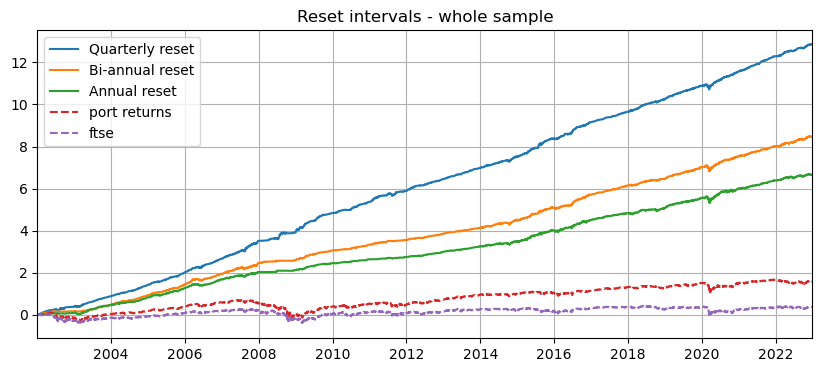

In [33]:
plt.figure(figsize=(10,4))
plt.title('Reset intervals - whole sample')
plt.margins(x=0)
plt.plot(np.cumsum(quarterlyReset), label='Quarterly reset')
plt.plot(np.cumsum(biAnnualReset), label='Bi-annual reset')
plt.plot(np.cumsum(annualReset), label='Annual reset')
plt.plot(np.cumsum(portfolio.portlogReturns), label='port returns', ls='--')
plt.plot(np.cumsum(ftseLogReturn), label='ftse', ls='--')
plt.grid()
plt.legend()
plt.savefig('media/Bannual_reset')
plt.show()

### Out of sample - forward static window

In [34]:
# Forward Annual
shiftedRet = portfolio.logReturns.shift(-(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])))
FannualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
FannualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.groupby(portfolio.logReturns.index.year):
    mean = x.mean()
    cov = x.cov()
    FannualReset['ret'][x.index]= shiftedRet.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
FannualReset = FannualReset.shift(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index[0].year])).dropna()
# Forward FBiAnnual
shiftedRetBannual = portfolio.logReturns.shift(-int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/2))
FBiAnnualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
FBiAnnualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('6M',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    FBiAnnualReset['ret'][x.index] = shiftedRetBannual.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
FBiAnnualReset = FBiAnnualReset.shift(int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/2))
# Forward Quarterly
shiftedRetQuarterly = portfolio.logReturns.shift(-int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/2))
FQuarterlyReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
FQuarterlyReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('Q',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    FQuarterlyReset['ret'][x.index] = shiftedRetQuarterly.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
FQuarterlyReset = FQuarterlyReset.shift(int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/4))

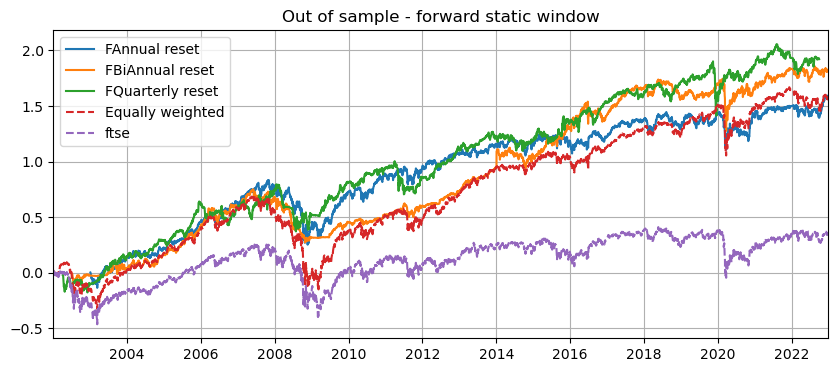

In [35]:
plt.figure(figsize=(10,4))
plt.title('Log returns')
plt.margins(x=0)
#plt.plot(np.cumsum(annualReset), label='Annual reset', ls=':')
plt.plot(np.cumsum(FannualReset.dropna()), label='FAnnual reset')
plt.plot(np.cumsum(FBiAnnualReset.dropna()), label='FBiAnnual reset')
plt.plot(np.cumsum(FQuarterlyReset.dropna()), label='FQuarterly reset')
plt.plot(np.cumsum(portfolio.portlogReturns), label='Equally weighted', ls='--')
plt.plot(np.cumsum(ftseLogReturn), label='ftse', ls='--')
plt.title('Out of sample - forward static window')
plt.grid()
plt.legend()
plt.show()

### Cumulative sample - static forward window

In [36]:
# Forward cumulative Annual
CannualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=np.nan),index=portfolio.logReturns.index)
CannualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('1Y',label='right',closed='left'):
    meanReturns = portfolio.logReturns[:i].mean()
    covMatrix = portfolio.logReturns[:i].cov()
    CannualReset['ret'][i:i+relativedelta(years=1)]= portfolio.logReturns[i:i+relativedelta(years=1)] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
# Forward cumulative BiAnnual    
CBiAnnualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=np.nan),index=portfolio.logReturns.index)
CBiAnnualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('6m',label='right',closed='left'):
    meanReturns = portfolio.logReturns[:i].mean()
    covMatrix = portfolio.logReturns[:i].cov()
    CBiAnnualReset['ret'][i:i+relativedelta(months=+6)]= portfolio.logReturns[i:i+relativedelta(months=+6)] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
# Forward cumulative quarterly
CQuarterlyReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=np.nan),index=portfolio.logReturns.index)
CQuarterlyReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('3m',label='right',closed='left'):
    meanReturns = portfolio.logReturns[:i].mean()
    covMatrix = portfolio.logReturns[:i].cov()
    CQuarterlyReset['ret'][i:i+relativedelta(months=+3)]= portfolio.logReturns[i:i+relativedelta(months=+3)] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T

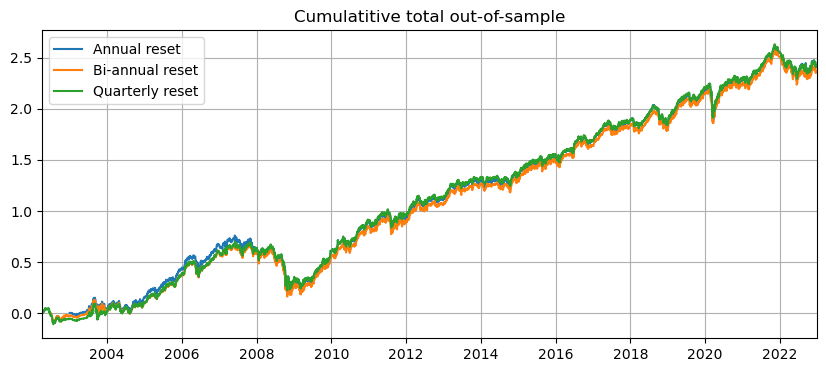

In [37]:
plt.figure(figsize=(10,4))
plt.title('Log returns')
plt.margins(x=0)
plt.plot(np.cumsum(CannualReset.dropna()), label='Annual reset')
plt.plot(np.cumsum(CBiAnnualReset).dropna(), label='Bi-annual reset')
plt.plot(np.cumsum(CQuarterlyReset), label='Quarterly reset')
plt.title('Cumulatitive total out-of-sample')
plt.grid()
plt.legend()
plt.show()

# Check if weights actually change significantly

In [38]:
resetWeights = {}
for i,x in portfolio.logReturns.resample('1Y',label='right',closed='left'):
    meanReturns = portfolio.logReturns[:i].mean()
    covMatrix = portfolio.logReturns[:i].cov()
    resetWeights[i.date()] = (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T


In [39]:
evoWeights = pd.DataFrame(resetWeights).T
evoWeights.columns = portfolio.logReturns.columns.to_list()
weightsComp = portfolio.raw_data['Adj Close'].iloc[0].values@evoWeights.T

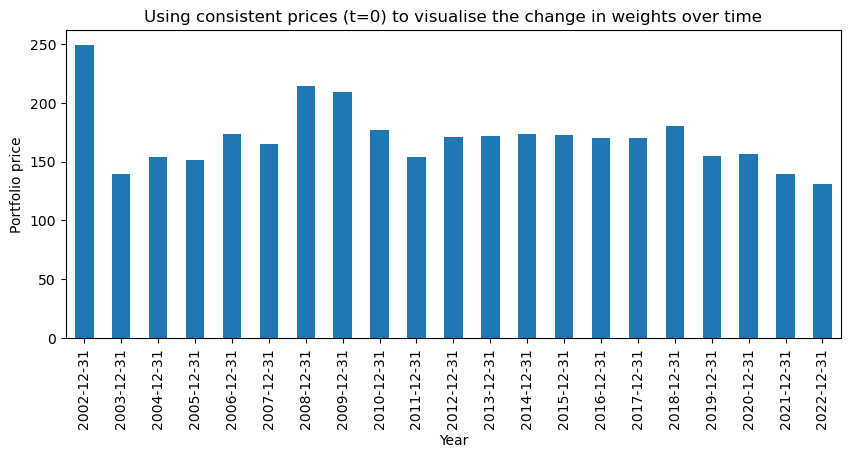

In [40]:
plt.figure(figsize=(10,4))
weightsComp.plot.bar()
plt.ylabel('Portfolio price')
plt.xlabel('Year')
plt.title('Using consistent prices (t=0) to visualise the change in weights over time')
plt.savefig('media/EvolutionOfWeights')
plt.show()

In [41]:
fig = px.imshow(evoWeights,
              labels=dict(x="Changes to distribution of weights", y="Year", color="Weight"),
                color_continuous_scale='viridis'
               )
fig.update_layout(
    title='Change in distribution of weights'
)
fig.show()

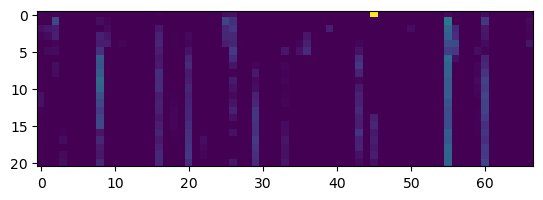

In [42]:
plt.imshow(evoWeights)

# Results

### Best reset samples

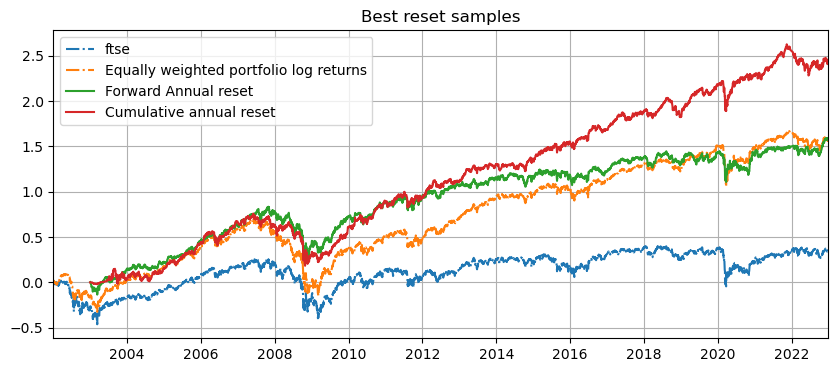

In [43]:
plt.figure(figsize=(10,4))
plt.margins(x=0)
plt.plot(np.cumsum(ftseLogReturn), label='ftse', ls='-.')
plt.plot(np.cumsum(portfolio.portlogReturns), label='Equally weighted portfolio log returns', ls='-.')
plt.plot(np.cumsum(FannualReset.dropna()), label='Forward Annual reset')
plt.plot(np.cumsum(CannualReset.dropna()), label='Cumulative annual reset')
plt.title('Best reset samples')
plt.grid()
plt.legend()
plt.savefig('media/BestResetSamples')
plt.show()

In [44]:
reset_samples = [ftseLogReturn,portfolio.portlogReturns,FannualReset,CannualReset]
reset_samples_str = ['ftseLogReturn','equallyWeightedLogReturns','FannualReset','CannualReset']
res = {}
for i,x in zip(reset_samples_str, reset_samples):
    res[i] = {
        'AvLReturn': pd.Series(x.dropna().sum()).values[0],
        'std': pd.Series(x.dropna().std()).values[0],
    }
reset_res = pd.DataFrame(res)

In [45]:
reset_res

ftseLogReturn  equallyWeightedLogReturns  FannualReset  \
AvLReturn       0.356271                   1.570572      1.587177   
std             0.011684                   0.010837      0.010524   

           CannualReset  
AvLReturn      2.421074  
std            0.010445

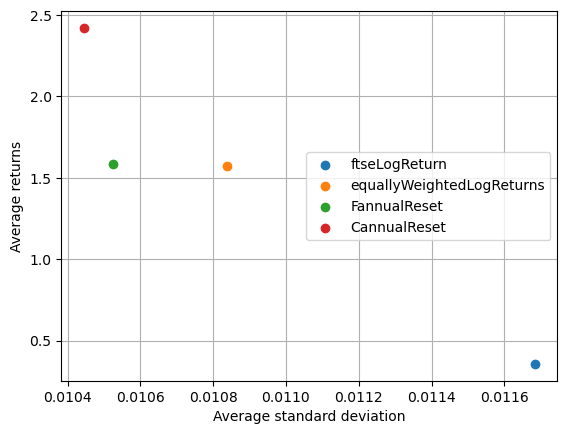

In [46]:
for i in reset_res:
    plt.scatter(reset_res[i]['std'],reset_res[i]['AvLReturn'],label=i)
plt.ylabel('Average returns')
plt.xlabel('Average standard deviation')
plt.grid()
plt.legend(loc=5)

#### Beta

In [47]:
for i,x in zip(reset_samples_str[1:], reset_samples[1:]):
    df = pd.concat([x,ftseLogReturn],axis=1).dropna()
    res[i]['beta'] = np.round(np.cov(df[df.columns[0]],df[df.columns[1]])[0][1]/df['Adj Close'].var(),5)

#### Alpha

In [48]:
#Alpha = R – Rf – beta (Rm-Rf)
for i,x in zip(reset_samples_str[1:], reset_samples[1:]):
   # df = pd.concat([portfolio.portlogReturns,ftseLogReturn],axis=1).dropna()
    res[i]['alpha'] = np.round(res[i]['AvLReturn']-(res[i]['beta']*(df['Adj Close'].mean())),5)

In [49]:
alphaBeta = pd.DataFrame(res).T

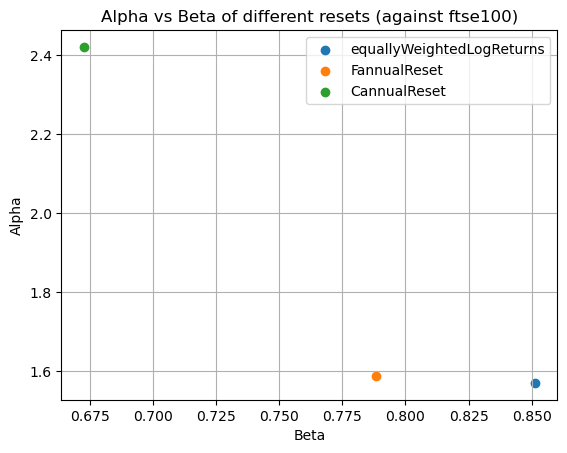

In [50]:
for i in alphaBeta.iloc[1:].T:
    plt.scatter(alphaBeta.T[i]['beta'],alphaBeta.T[i]['alpha'],label=i)
plt.title('Alpha vs Beta of different resets (against ftse100)')
plt.legend()
plt.grid()
plt.xlabel('Beta')
plt.ylabel('Alpha')
plt.savefig('media/AlphaBeta')
plt.show()

# Optimiser

In [52]:
class optPort:
    def __init__(self, tickers, start, end, optimiseBy= 'maxSharpe', riskFreeRate=0, constraintSet=(0,1), logReturns=True, threshold=0.8, drop_extremes=True, excess=5, dateRange=None):
        self.portfolio = pt.Portfolio(tickers, start, end)
        self.portfolio.getData()
        self.portfolio.cleanData(threshold=threshold, drop_extremes=drop_extremes, excess=excess, dateRange=dateRange)
        self.portfolio.calculate_stats(logReturns=logReturns)
        self.portfolio.calculate_PortPerformance(pt.equallyWeighted(self.portfolio.logReturns.mean(),self.portfolio.logReturns.cov())[1][1])
        self.optimiseBy = optimiseBy
    def testConstraints(self,riskFreeRate=0,constraintSet=(0,1)):
        def optimiser(meanReturns,covMatrix, riskFreeRate=riskFreeRate, constraintSet=constraintSet):
            if self.optimiseBy=='maxSR':
                return pt.maxSharpeRatio(meanReturns,covMatrix, riskFreeRate=riskFreeRate, constraintSet=constraintSet)
            elif self.optimiseBy=='minVol':
                return pt.minimizeVariance(meanReturns,covMatrix, constraintSet=constraintSet)
        meanReturns = self.portfolio.logReturns.mean()
        covMatrix = self.portfolio.covMatrix
        w0001 = optimiser(meanReturns,covMatrix,constraintSet=(0.0001, 1))
        w001 = optimiser(meanReturns,covMatrix,constraintSet=(0.001, 1))
        w01 = optimiser(meanReturns,covMatrix,constraintSet=(0.01, 1))
        w = optimiser(meanReturns,covMatrix)
        fig, axs = plt.subplots(2,2,figsize=(10,4), layout='constrained', sharey=True, sharex=True)
        fig.suptitle('Distribution of weights with various contraints', fontsize=15)
        fig.supylabel('Weight')
        fig.supxlabel('Asset index')
        axs[0][0].bar(np.arange(1,len(w0001[1][1])+1),height=w0001[1][1])
        axs[0][0].set_title('contraintSet=(0.0001, 1)')
        axs[0][1].bar(np.arange(1,len(w001[1][1])+1),height=w001[1][1])
        axs[0][1].set_title('contraintSet=(0.001, 1)')
        axs[1][0].bar(np.arange(1,len(w01[1][1])+1),height=w01[1][1])
        axs[1][0].set_title('contraintSet=(0.01, 1)')
        axs[1][1].bar(np.arange(1,len(w[1][1])+1),height=w[1][1])
        axs[1][1].set_title('contraintSet=(0, 1)')
        for i in axs.flatten():
            i.grid(visible=True,which='both',linewidth=0.3)
            i.margins(x=0)
        plt.show()
        df = pd.concat([pd.DataFrame(w0001[1]).T.set_index(0),
                 pd.DataFrame(w001[1]).T.set_index(0), 
                 pd.DataFrame(w01[1]).T.set_index(0), 
                 pd.DataFrame(w[1]).T.set_index(0)], axis=1)
        df.columns = ['(0.0001, 1)','(0.001, 1)','(0.01, 1)','(0, 1)']
        df.index.name = 'ConstraintSet'
        df = (df*100).astype(float).round(2)
        return df.T.astype(str) + '%'
    def testResetMovingWindow(self,riskFreeRate=0,constraintSet=(0,1)):
        def optimiser(meanReturns,covMatrix, riskFreeRate=riskFreeRate, constraintSet=constraintSet):
            if self.optimiseBy=='maxSR':
                return pt.maxSharpeRatio(meanReturns,covMatrix, riskFreeRate=riskFreeRate, constraintSet=constraintSet)
            elif self.optimiseBy=='minVol':
                return pt.minimizeVariance(meanReturns,covMatrix, constraintSet=constraintSet)
        # Forward FAnnual
        shiftedRet = self.portfolio.logReturns.shift(-(len(self.portfolio.logReturns[self.portfolio.logReturns.index.year==self.portfolio.logReturns.index.year[0]])))
        FannualReset = pd.DataFrame(np.full(len(self.portfolio.logReturns),fill_value=0.0),index=self.portfolio.logReturns.index)
        FannualReset.rename(columns={0:'ret'}, inplace=True)
        for i,x in self.portfolio.logReturns.groupby(self.portfolio.logReturns.index.year):
            meanReturns = x.mean()
            covMatrix = x.cov()
            FannualReset['ret'][x.index]= shiftedRet.loc[x.index] @ (optimiser(meanReturns,covMatrix)[1][1]).T
        FannualReset = FannualReset.shift(len(self.portfolio.logReturns[self.portfolio.logReturns.index.year==self.portfolio.logReturns.index[0].year])).dropna()
        # Forward FBiAnnual
        shiftedRetBannual = self.portfolio.logReturns.shift(-int(len(self.portfolio.logReturns[self.portfolio.logReturns.index.year==self.portfolio.logReturns.index.year[0]])/2))
        FBiAnnualReset = pd.DataFrame(np.full(len(self.portfolio.logReturns),fill_value=0.0),index=self.portfolio.logReturns.index)
        FBiAnnualReset.rename(columns={0:'ret'}, inplace=True)
        for i,x in self.portfolio.logReturns.resample('6M',label='right',closed='left'):
            meanReturns = x.mean()
            covMatrix = x.cov()
            FBiAnnualReset['ret'][x.index] = shiftedRetBannual.loc[x.index] @ (optimiser(meanReturns,covMatrix)[1][1]).T
        FBiAnnualReset = FBiAnnualReset.shift(int(len(self.portfolio.logReturns[self.portfolio.logReturns.index.year==self.portfolio.logReturns.index.year[0]])/2))
        # Forward Quarterly
        shiftedRetQuarterly = self.portfolio.logReturns.shift(-int(len(self.portfolio.logReturns[self.portfolio.logReturns.index.year==self.portfolio.logReturns.index.year[0]])/4))
        FQuarterlyReset = pd.DataFrame(np.full(len(self.portfolio.logReturns),fill_value=0.0),index=self.portfolio.logReturns.index)
        FQuarterlyReset.rename(columns={0:'ret'}, inplace=True)
        for i,x in self.portfolio.logReturns.resample('Q',label='right',closed='left'):
            meanReturns = x.mean()
            covMatrix = x.cov()
            FQuarterlyReset['ret'][x.index] = shiftedRetQuarterly.loc[x.index] @ (optimiser(meanReturns,covMatrix)[1][1]).T
        FQuarterlyReset = FQuarterlyReset.shift(int(len(self.portfolio.logReturns[self.portfolio.logReturns.index.year==self.portfolio.logReturns.index.year[0]])/4))
        df = pd.concat([FannualReset,FBiAnnualReset,FQuarterlyReset], axis=1)
        df.columns = ['Annual Reset','Bi-annual Reset','Quarterly Reset']
        df.cumsum().plot(figsize=(12,4)); plt.legend();plt.margins(x=0), plt.grid()
        plt.title('Comparing the frequency of resetting the weights from backwards looking window')        
        return df
    
    def testResetCumulativeSample(self,riskFreeRate=0,constraintSet=(0,1)):
        def optimiser(meanReturns,covMatrix, riskFreeRate=riskFreeRate, constraintSet=constraintSet):
            if self.optimiseBy=='maxSR':
                return pt.maxSharpeRatio(meanReturns,covMatrix, riskFreeRate=riskFreeRate, constraintSet=constraintSet)
            elif self.optimiseBy=='minVol':
                return pt.minimizeVariance(meanReturns,covMatrix, constraintSet=constraintSet)
        # Forward cumulative Annual
        CannualReset = pd.DataFrame(np.full(len(self.portfolio.logReturns),fill_value=np.nan),index=self.portfolio.logReturns.index)
        CannualReset.rename(columns={0:'ret'}, inplace=True)
        for i,x in self.portfolio.logReturns.resample('1Y',label='right',closed='left'):
            meanReturns = self.portfolio.logReturns[:i].mean()
            covMatrix = self.portfolio.logReturns[:i].cov()
            CannualReset['ret'][i:i+relativedelta(years=1)]= self.portfolio.logReturns[i:i+relativedelta(years=1)] @ (optimiser(meanReturns,covMatrix)[1][1]).T
        # Forward cumulative BiAnnual    
        CBiAnnualReset = pd.DataFrame(np.full(len(self.portfolio.logReturns),fill_value=np.nan),index=self.portfolio.logReturns.index)
        CBiAnnualReset.rename(columns={0:'ret'}, inplace=True)
        for i,x in self.portfolio.logReturns.resample('6m',label='right',closed='left'):
            meanReturns = self.portfolio.logReturns[:i].mean()
            covMatrix = self.portfolio.logReturns[:i].cov()
            CBiAnnualReset['ret'][i:i+relativedelta(months=+6)]= self.portfolio.logReturns[i:i+relativedelta(months=+6)] @ (optimiser(meanReturns,covMatrix)[1][1]).T
        # Forward cumulative quarterly
        CQuarterlyReset = pd.DataFrame(np.full(len(self.portfolio.logReturns),fill_value=np.nan),index=self.portfolio.logReturns.index)
        CQuarterlyReset.rename(columns={0:'ret'}, inplace=True)
        for i,x in self.portfolio.logReturns.resample('3m',label='right',closed='left'):
            meanReturns = self.portfolio.logReturns[:i].mean()
            covMatrix = self.portfolio.logReturns[:i].cov()
            CQuarterlyReset['ret'][i:i+relativedelta(months=+3)]= self.portfolio.logReturns[i:i+relativedelta(months=+3)] @ (optimiser(meanReturns,covMatrix)[1][1]).T
        df = pd.concat([CannualReset,CBiAnnualReset,CQuarterlyReset], axis=1)
        df.columns = ['Annual Reset','Bi-annual Reset','Quarterly Reset']
        df.cumsum().plot(figsize=(12,4)); plt.legend();plt.margins(x=0), plt.grid()
        plt.title('Comparing the frequency of resetting the weights with cumulative sample')        
        return df
    
    def testRatios(self, data):
        res = {}
        df = pd.concat([self.portfolio.portReturns, data],axis=1)
        df.rename(columns={0:'EquallyWeighted benchmark'}, inplace=True)
        for i in df.columns[1:]:
            data = df[['EquallyWeighted benchmark',i]].dropna()#pd.concat([df['EquallyWeighted benchmark'],df[i]],axis=1).dropna()
            res[i]= {}
            res[i]['beta'] = np.round(data.cov().iloc[0][1]/data[i].var(),5)
            #Alpha = R – Rf – beta (Rm-Rf)
            res[i]['alpha'] = np.round(data[i].mean()-(res[i]['beta']*(df['EquallyWeighted benchmark'].mean())),5)
            results = (pd.DataFrame(res))
        for i in results:
            plt.scatter(results[i]['alpha'],results[i]['beta'],label=i)
        plt.title('Alpha vs Beta of different resets (measured against an equally weighted distribution)')
        plt.legend()
        plt.grid()
        plt.xlabel('Beta')
        plt.ylabel('Alpha')
        plt.xticks(rotation=90)
        plt.show()
        return results

In [53]:
tickers = ticks.simple
start=dt.datetime(2000,1,1)
end=dt.datetime(2023,1,1)
threshold=0.9

port = optPort(tickers, start, end, logReturns=True, optimiseBy='minVol', threshold=0.5)

[*********************100%***********************]  3 of 3 completed
No NAs found


In [54]:
port.portfolio.raw_data.to_csv('simple_rawData.csv')

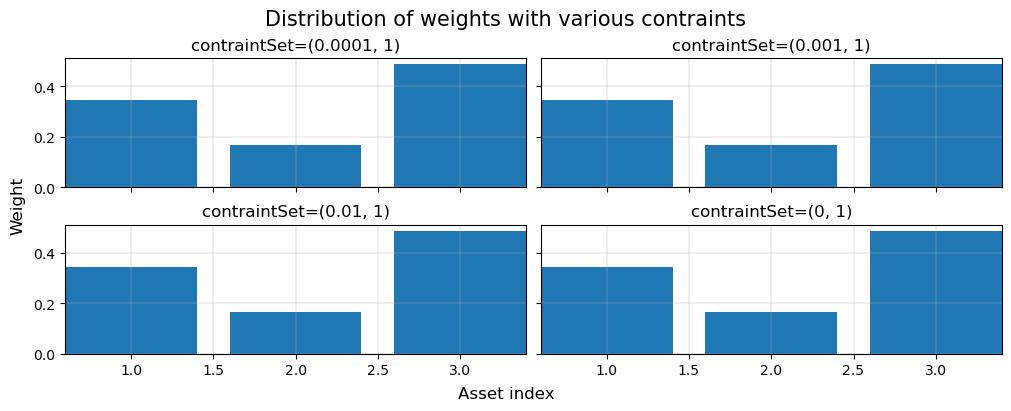

In [55]:
c = port.testConstraints()

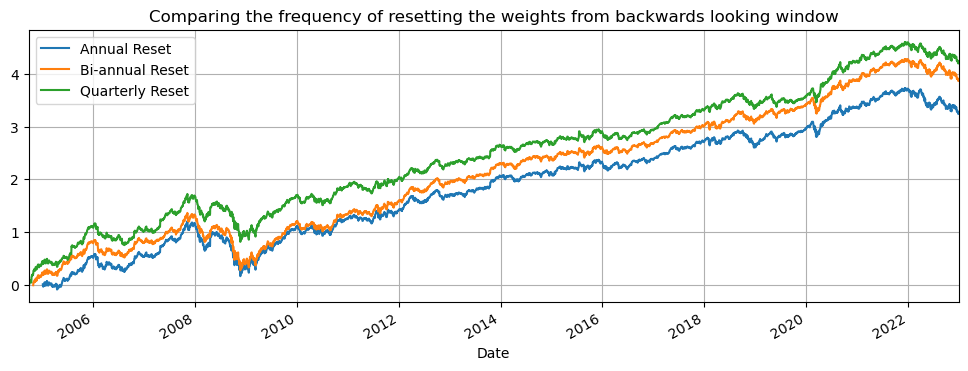

In [56]:
a = port.testResetMovingWindow()

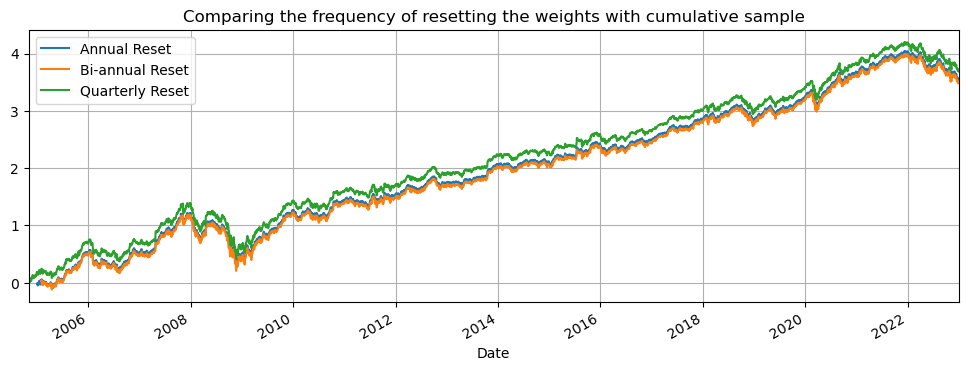

In [57]:
b = port.testResetCumulativeSample()

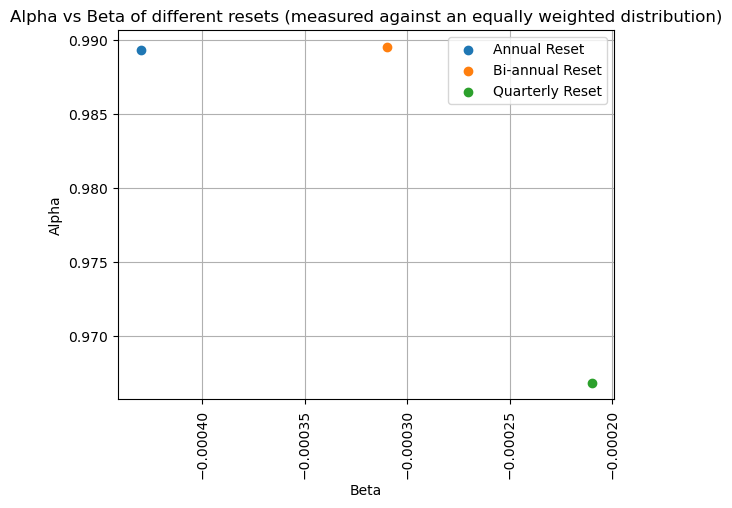

Annual Reset  Bi-annual Reset  Quarterly Reset
beta        0.98929          0.98954          0.96687
alpha      -0.00043         -0.00031         -0.00021

In [58]:
port.testRatios(a)

In [59]:
test = testRatios(a)

NameError: name 'testRatios' is not defined

In [ ]:
testRatios(b)

In [ ]:
port.portfolio.portlogReturns.cumsum().plot(label='port')
a['Annual Reset'].dropna().cumsum().plot(label='optimised')
ftseLogReturn.cumsum().plot(label='ftse')
plt.legend()

In [ ]:
a.std()

In [ ]:
b.std()

In [ ]:
port.portfolio.portlogReturns.std()